# Using a modified  version of Resnet50 for Recognizing American Handsign language

<img src ='american_sign_language.PNG'>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as  plt
import keras
import pydot
from IPython.display import  SVG
import scipy.misc
from matplotlib.pyplot import imshow
from resnets_utils import *
from  sklearn.model_selection import train_test_split as tts

Using TensorFlow backend.
/home/arun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train_df=pd.read_csv("sign_mnist_train.csv")
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
train_np=np.array(train_df)

test_df=pd.read_csv("sign_mnist_test.csv")
test_np=np.array(test_df)

#extcting the images from taining set
train_labels=train_np[:,0]
train_data=train_np[:,1:]
train_data=train_data.reshape(train_data.shape[0],28,28,1)

test_labels=test_np[:,0]
test_data=test_np[:,1:]
test_data=test_data.reshape(test_data.shape[0],28,28,1)

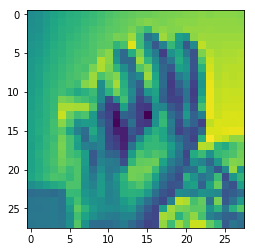

In [54]:
plt.imshow(train_data[31].reshape(28,28))
plt.show()

## Data set currently used 
<img src="amer_sign3.png">

In [7]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    X = keras.layers.add([X,X_shortcut])
    X = keras.layers.Activation('relu')(X)
    return X

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 1):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = keras.layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding='valid', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Conv2D(F2, (f,f),strides=(1,1), name=conv_name_base+'2b',padding='same',kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Conv2D(F3,(1,1),strides=(1,1),name=conv_name_base+'2c',padding='valid',kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    X_shortcut = keras.layers.Conv2D(F3,(1,1),strides=(s,s),name=conv_name_base+'1',padding='valid',kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)
    X = keras.layers.add([X,X_shortcut])
    X = keras.layers.Activation('relu')(X)
    return X

In [9]:
def ResNet50(input_shape = (None, 28, 28, 1), classes = 6):
    X_input = keras.Input(input_shape)
    X = keras.layers.ZeroPadding2D((3, 3))(X_input)
    X = keras.layers.Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a')
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    X = identity_block(X,3,[128,128,512],stage=3,block='d')
    X = convolutional_block(X,3,[256,256,1024],4,'a',2)
    X = identity_block(X,3,[256,256,1024],stage=4,block='b')
    X = identity_block(X,3,[256,256,1024],stage=4,block='c')
    X = identity_block(X,3,[256,256,1024],stage=4,block='d')
    X = identity_block(X,3,[256,256,1024],stage=4,block='e')
    X = identity_block(X,3,[256,256,1024],stage=4,block='f')
    X = convolutional_block(X,3,[512,512,2048],stage=5,block='a',s=2)
    X = identity_block(X,3,[512,512,2048],stage=5,block='b')
    X = identity_block(X,3,[512,512,2048],stage=5,block='c')
    X = keras.layers.AveragePooling2D((2,2),name='avg_pool')(X)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    model = keras.models.Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [10]:
model = ResNet50(input_shape = (28, 28, 1), classes = 25)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 34, 34, 1)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 14, 14, 64)    3200        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 14, 14, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
Y_train = convert_to_one_hot(train_labels, 25).T
Y_test = convert_to_one_hot(test_labels, 25).T

X_train = train_data/255.
X_test = test_data/255.

In [12]:
X_train.shape

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 27455
number of test examples = 7172
X_train shape: (27455, 28, 28, 1)
Y_train shape: (27455, 25)
X_test shape: (7172, 28, 28, 1)
Y_test shape: (7172, 25)


## Train the model till it converges

It took roughly 6hrs to get decent performance in test

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

## After Training can be serialized and saved to disk

In [ ]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [13]:
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

7168/7172 [============================>.] - ETA: 0sLoss = 0.832292457575
Test Accuracy = 0.889570552147
